In [1]:
!nvidia-smi

Tue Mar 26 17:33:24 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.13    Driver Version: 525.60.13    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                  Off |
| N/A   36C    P0    51W / 300W |  10576MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
!pip install -q -U bitsandbytes
!pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git

In [2]:
import torch
torch.cuda.is_available()

True

## 모델 불러오기

### 4bit Quantization

In [86]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel


model_id = "EleutherAI/polyglot-ko-1.3b" # 'beomi/OPEN-SOLAR-KO-10.7B' 
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0}, cache_dir='./cache')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  1.73it/s]


### QLoRA setting

In [80]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [66]:
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# kbit training
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# lora config
config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["query_key_value"], #["q_proj","up_proj","o_proj","k_proj","down_proj","gate_proj","v_proj"], 
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# peft model
model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 1572864 || all params: 729403392 || trainable%: 0.21563705588032142


## 데이터 마련

In [67]:
import pandas as pd

total_df = pd.read_csv('filtered_total.csv')
total_df

,id,session_dialog,session_persona
0,K2-10540-CL12939-CP35150-09-05-S2.json,"['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이...",['나는 가끔 외로워서 반려동물을 키워보고 싶다. 나는 유기견 입양에 대해 고민하고...
1,K2-34114-CL01643-CP00208-06-18-S2.json,"['안녕. 20대 여자야. 반가워.', '아니, 나는 무교야. 너는?', '어떤 일...","['나는 종교가 없다.', '나는 펀드매니저이다.', '나는 좋아하는 음식으로 기분..."
2,K2-33618-CL20065-CP22132-16-13-S2.json,"['며칠이 지났는지 날짜도 모르겠네. 일주일이 지났어?', '시간이 너무 빨리 가....",['나는 선후배와 잘 어울리지 않는다.']
3,K2-19873-CL20525-CP22570-06-09-S2.json,"['응, 선생님은 준비 잘 하고 있어?', '선생님은 왜 가게 되셨는지 여쭤봐도 될...","['나는 영문학과이다.', '나는 음식을 배우기 위해 미국으로 간다.']"
4,K2-05407-CL01467-CP01154-14-03-S2.json,"['응, 하긴 했어. 청소하는 게 짜증나. 너는 무슨 영화를 봤어?', '아니, 나...","['나는 청소하는 게 짜증 난다.', '나는 영화를 안 좋아한다.', '나는 위인전..."
...,...,...,...
2325,K2-26129-CL23839-CP24690-03-05-S2.json,"['안녕, 나는 20대 여자야. 반가워.', '뭐하고 있었어? 난 SF 영화를 가끔...","['나는 SF 영화를 가끔 본다. 나는 오늘 영화 그래비티를 재미있게 봤다.', '..."
2326,K2-34387-CL21846-CP22413-03-04-S2.json,"['안녕, 어제는 잘 잤어? 이제 곧 5시네.', '나도 지금 준비중이긴 한데, 지...",['나는 요즘 전기차가 많이 늘어났다고 생각한다.']
2327,K2-06850-CL00979-CP04444-19-04-S2.json,"['안녕, 나는 20대 남자야.', '오, 나이가 좀 있으신 분이시네. 어디 사세요...","['나의 고향은 전라도이다. 나는 현재 서울에 거주하고 있다.', '나는 연예인 지..."
2328,K2-07302-CL20306-CP22594-16-01-S2.json,"['5시간이나 지났어? 시간 가는줄도 몰랐네, 다녀왔어.', '아니, 사실 내 입맛...","['나는 커피가 나의 입맛에 맞지 않았다.', '나는 피부가 별로이다.', '나의 ..."


### [no persona] special token 추가

In [87]:
print("[no_persona] 개수 : ", len(total_df[total_df['session_persona']=="['[no_persona]']"]))
print('------------------------------------------------------------------------------------------------')
print('default tokenizer vocab_size :', len(tokenizer))
print("default tokenizer의 [no_persona] tokenizing :", tokenizer.encode("[no_persona]"))

# tokenizer에 [no_persona] 추가
tokenizer.add_special_tokens({'additional_special_tokens': ["[no_persona]"]})

print('------------------------------------------------------------------------------------------------')
print('added tokenizer vocab_size :', len(tokenizer))
print("added tokenizer의 [no_persona] tokenizing :", tokenizer.encode("[no_persona]"))

print('------------------------------------------------------------------------------------------------')
print('added tokenizer의 special_tokens :', tokenizer.special_tokens_map)

# model resize
model.resize_token_embeddings(len(tokenizer))


[no_persona] 개수 :  125
------------------------------------------------------------------------------------------------
default tokenizer vocab_size : 30003
default tokenizer의 [no_persona] tokenizing : [62, 81, 82, 66, 83, 13151, 2600, 68, 64]
------------------------------------------------------------------------------------------------
added tokenizer vocab_size : 30004
added tokenizer의 [no_persona] tokenizing : [30003]
------------------------------------------------------------------------------------------------
added tokenizer의 special_tokens : {'eos_token': '<|endoftext|>', 'pad_token': '<|endoftext|>', 'additional_special_tokens': ['[no_persona]']}


Embedding(30004, 2048)

### 데이터셋 만들기

In [88]:
def makedata(ses_dialog, ses_persona):
        return f"### 사용자 채팅: {ses_dialog}</끝>\n### 사용자 페르소나: {ses_persona}</끝>"

In [89]:
from tqdm import tqdm

total_df['text']=None

for i,row in tqdm(total_df.iterrows()):
    total_df.loc[i,'text']=(makedata(row['session_dialog'], row['session_persona']))

2330it [00:00, 4659.48it/s]


In [91]:
total_df

,id,session_dialog,session_persona,text
0,K2-10540-CL12939-CP35150-09-05-S2.json,"['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이...",['나는 가끔 외로워서 반려동물을 키워보고 싶다. 나는 유기견 입양에 대해 고민하고...,"### 사용자 채팅: ['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을..."
1,K2-34114-CL01643-CP00208-06-18-S2.json,"['안녕. 20대 여자야. 반가워.', '아니, 나는 무교야. 너는?', '어떤 일...","['나는 종교가 없다.', '나는 펀드매니저이다.', '나는 좋아하는 음식으로 기분...","### 사용자 채팅: ['안녕. 20대 여자야. 반가워.', '아니, 나는 무교야...."
2,K2-33618-CL20065-CP22132-16-13-S2.json,"['며칠이 지났는지 날짜도 모르겠네. 일주일이 지났어?', '시간이 너무 빨리 가....",['나는 선후배와 잘 어울리지 않는다.'],"### 사용자 채팅: ['며칠이 지났는지 날짜도 모르겠네. 일주일이 지났어?', '..."
3,K2-19873-CL20525-CP22570-06-09-S2.json,"['응, 선생님은 준비 잘 하고 있어?', '선생님은 왜 가게 되셨는지 여쭤봐도 될...","['나는 영문학과이다.', '나는 음식을 배우기 위해 미국으로 간다.']","### 사용자 채팅: ['응, 선생님은 준비 잘 하고 있어?', '선생님은 왜 가게..."
4,K2-05407-CL01467-CP01154-14-03-S2.json,"['응, 하긴 했어. 청소하는 게 짜증나. 너는 무슨 영화를 봤어?', '아니, 나...","['나는 청소하는 게 짜증 난다.', '나는 영화를 안 좋아한다.', '나는 위인전...","### 사용자 채팅: ['응, 하긴 했어. 청소하는 게 짜증나. 너는 무슨 영화를 ..."
...,...,...,...,...
2325,K2-26129-CL23839-CP24690-03-05-S2.json,"['안녕, 나는 20대 여자야. 반가워.', '뭐하고 있었어? 난 SF 영화를 가끔...","['나는 SF 영화를 가끔 본다. 나는 오늘 영화 그래비티를 재미있게 봤다.', '...","### 사용자 채팅: ['안녕, 나는 20대 여자야. 반가워.', '뭐하고 있었어?..."
2326,K2-34387-CL21846-CP22413-03-04-S2.json,"['안녕, 어제는 잘 잤어? 이제 곧 5시네.', '나도 지금 준비중이긴 한데, 지...",['나는 요즘 전기차가 많이 늘어났다고 생각한다.'],"### 사용자 채팅: ['안녕, 어제는 잘 잤어? 이제 곧 5시네.', '나도 지금..."
2327,K2-06850-CL00979-CP04444-19-04-S2.json,"['안녕, 나는 20대 남자야.', '오, 나이가 좀 있으신 분이시네. 어디 사세요...","['나의 고향은 전라도이다. 나는 현재 서울에 거주하고 있다.', '나는 연예인 지...","### 사용자 채팅: ['안녕, 나는 20대 남자야.', '오, 나이가 좀 있으신 ..."
2328,K2-07302-CL20306-CP22594-16-01-S2.json,"['5시간이나 지났어? 시간 가는줄도 몰랐네, 다녀왔어.', '아니, 사실 내 입맛...","['나는 커피가 나의 입맛에 맞지 않았다.', '나는 피부가 별로이다.', '나의 ...","### 사용자 채팅: ['5시간이나 지났어? 시간 가는줄도 몰랐네, 다녀왔어.', ..."


In [90]:
total_df['text'][0]

"### 사용자 채팅: ['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이 많더라.', '대단하네. 나도 가끔 외로워서 반려동물을 키워보고 싶은데, 유기견을 입양해볼까 고민이 많아.', '맞아. 유기견 봉사활동 같은 것도 많은 것 같아. 나중에 기회가 되면 한번 가봐야겠어.', '요즘 밴드나 알아볼 수 있는 방법들이 많다고 들었어.  찾아보면 될 것 같아.', '맞아, 혼자 가서 할 수 있는 일도 아니야. 한번 알아봐.', '아니, 나도 관심은 있는데, 키우기는 조금 부담이 돼.']</끝>\n### 사용자 페르소나: ['나는 가끔 외로워서 반려동물을 키워보고 싶다. 나는 유기견 입양에 대해 고민하고 있다.', '나는 반려동물에 관심이 있다. 나는 반려동물을 키우기에 부담이 된다.']</끝>"

### Tokenizing

In [92]:
# 토큰 길이 통계
total_df['text'].apply(lambda x: len(tokenizer.encode(x))).describe()

count    2330.000000
mean      221.142918
std        51.802716
min       114.000000
25%       185.000000
50%       214.000000
75%       248.000000
max       569.000000
Name: text, dtype: float64

In [93]:
# Tokenizing 후, Dataset 형태로 준비

class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        item = self.encodings[idx]
        return item

    def __len__(self):
        return len(self.encodings)
    

tokenized = []
for text in tqdm(total_df['text']):
    encoded = tokenizer.encode(text,return_tensors='pt',
                               return_token_type_ids=False, 
                               padding='max_length', 
                               max_length=600, # max_length 고려
                               truncation=True, 
                               return_attention_mask=False)
    tokenized.append(encoded)
    
dataset = Dataset(torch.cat(tokenized,dim=0))

100%|██████████| 2330/2330 [00:01<00:00, 1389.58it/s]


In [94]:
dataset[0]

tensor([    6,     6,     6, 12238, 16262,    29,  5485,    10, 13417,    15,
         1010,  7499,   348,    34,   401,   393,   380,   270,   978,    17,
         3042,   514,  1193,    15,  4851,  7030,  5447,   276,  4340,    34,
         3090,  5167,  1055,   270,   750,  4325,    17,  3042,   514,   360,
          539,   284,   978,    17,   462,   309,  6609,   882,   286,  6878,
         7030,  5447,   276,  4340,  6571,  1219,  3200,    15,  5167,  1055,
          276, 12025,   310, 15259,  2387,   270,   750,   399,    17,  3042,
          514,  3108,   399,    17,  5167,  1055,  3715,  2032,   734,   296,
          388,   309,   750,   296,   388,   734,   399,    17,  4788,   274,
         1903,   293,   740,   378,  5876,   409,  4581,   685,   348,    17,
         3042,   514, 10162,  7708,   392, 17715,   365,   327,   272,  1891,
         6214,   750,   682,   705,   450,   348,    17,   224,  8454,   378,
         1180,   388,   734,   399,    17,  3042,   514,  3108, 

### Trian Valid split

In [95]:
# 9대 1로 train,dev 분할

from sklearn.model_selection import train_test_split

train_dataset, dev_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

In [96]:
len(train_dataset), len(dev_dataset)

(2097, 233)

## Trainer

In [46]:
## Trainer

early_callback=transformers.EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.001)
tokenizer.pad_token = tokenizer.eos_token

trainer = transformers.Trainer(
    model=model,
    train_dataset=dataset,
    # eval_dataset=dev_dataset,
    args=transformers.TrainingArguments(
        output_dir="./outputs",
        overwrite_output_dir=True,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        fp16=True,
        save_total_limit=2,
        logging_steps=30,
        # report_to=["tensorboard"],
        num_train_epochs = 1,
        learning_rate=1e-4,
        # resume_from_checkpoint=True,
        lr_scheduler_type= "cosine", # "constant"
        # load_best_model_at_end = True,
        # evaluation_strategy='epoch',
        save_strategy='steps',
        #optim="paged_adamw_8bit"
        # vload_best_model_at_end=True
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
    # callbacks=[early_callback],

)


Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this 

In [82]:
## SFTTrainer

from trl import SFTTrainer
# SFTTrainer 사용할 경우
trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    peft_config=config,
    dataset_text_field="text",
    max_seq_length=None,
    tokenizer=tokenizer,
    args=transformers.TrainingArguments(
        output_dir="./outputs",
        overwrite_output_dir=True,
        per_device_train_batch_size=8,
        gradient_accumulation_steps=1,
        fp16=True,
        save_total_limit=2,
        logging_steps=30,
        # report_to=["tensorboard"],
        num_train_epochs = 1,
        learning_rate=1e-4,
        # resume_from_checkpoint=True,
        lr_scheduler_type= "cosine", # "constant"
        # load_best_model_at_end = True,
        # evaluation_strategy='epoch',
        # save_strategy='steps',
        # optim="paged_adamw_8bit"
        # load_best_model_at_end=True
    ),
    packing=False,
)

/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/trl/trainer/sft_trainer.py:245: UserWarning: You didn't pass a `max_seq_length` argument to the SFTTrainer, this will default to 1024
  warnings.warn(
/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/trl/trainer/sft_trainer.py:317: UserWarning: You passed a tokenizer with `padding_side` not equal to `right` to the SFTTrainer. This might lead to some unexpected behaviour due to overflow issues when training a model in half-precision. You might consider adding `tokenizer.padding_side = 'right'` to your code.
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [83]:
model.config.use_cache = False

trainer.train()

/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
30,6.683800
60,6.703600
90,6.746200
120,6.706200
150,6.737500
180,6.699800
210,6.706800
240,6.716900
270,6.696900


TrainOutput(global_step=292, training_loss=6.714487101933727, metrics={'train_runtime': 2176.832, 'train_samples_per_second': 1.07, 'train_steps_per_second': 0.134, 'total_flos': 8.9681796808704e+16, 'train_loss': 6.714487101933727, 'epoch': 1.0})

In [85]:
model.save_pretrained("./saved/beomi-OPEN-SOLAR-KO-10.7B-1ep")

In [48]:
model.eval()
model.config.use_cache = True  

In [49]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        for stop in self.stops:
            if torch.all((stop == input_ids[0][-len(stop):])).item():
                return True

        return False

stop_words = ["</끝>"]
stop_words_ids = [tokenizer(stop_word, return_tensors='pt')['input_ids'].squeeze().to('cuda') for stop_word in stop_words]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

In [50]:
def gen(chat=""):
    prompt = f"### 사용자 채팅: {chat}</끝>\n### 사용자 페르소나: "

    tokenized = tokenizer(
            prompt,
            return_tensors='pt',
            return_token_type_ids=False,
        )
    tokenized = {k: v.to('cuda') for k, v in tokenized.items()}
    gened = model.generate(
        **tokenized,
        max_new_tokens=100,
        temperature=0.6,
        num_beams=3,
        stopping_criteria=stopping_criteria
    )
    return tokenizer.decode(gened[0]).replace(prompt+" ", "")

In [89]:
def gen(chat=""):
    prompt = f"### 사용자 채팅: {chat}</끝>\n### 사용자 페르소나: "
    gened = model.generate(
        **tokenizer(
            prompt,
            return_tensors='pt',
            return_token_type_ids=False,
        ),
        max_new_tokens=100,
        temperature=0.6,
        num_beams=3,
        # stopping_criteria=stopping_criteria
    )
    return tokenizer.decode(gened[0]).replace(prompt+" ", "")

In [51]:
chat = ['안녕, 잘 지냈어? 2일만이네.', 
        '응, 혹시 반려동물을 키워? 요즘 유기견이 많더라.', 
        '대단하네. 나도 가끔 외로워서 반려동물을 키워보고 싶은데, 유기견을 입양해볼까 고민이 많아.', 
        '맞아. 유기견 봉사활동 같은 것도 많은 것 같아. 나중에 기회가 되면 한번 가봐야겠어.', 
        '요즘 밴드나 알아볼 수 있는 방법들이 많다고 들었어.  찾아보면 될 것 같아.', 
        '맞아, 혼자 가서 할 수 있는 일도 아니야. 한번 알아봐.', 
        '아니, 나도 관심은 있는데, 키우기는 조금 부담이 돼.']

target = ['나는 가끔 외로워서 반려동물을 키워보고 싶다. 나는 유기견 입양에 대해 고민하고 있다.', 
          '나는 반려동물에 관심이 있다. 나는 반려동물을 키우기에 부담이 된다.']

In [52]:
gen(chat=chat) # epoch 0

/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"### 사용자 채팅: ['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이 많더라.', '대단하네. 나도 가끔 외로워서 반려동물을 키워보고 싶은데, 유기견을 입양해볼까 고민이 많아.', '맞아. 유기견 봉사활동 같은 것도 많은 것 같아. 나중에 기회가 되면 한번 가봐야겠어.', '요즘 밴드나 알아볼 수 있는 방법들이 많다고 들었어.  찾아보면 될 것 같아.', '맞아, 혼자 가서 할 수 있는 일도 아니야. 한번 알아봐.', '아니, 나도 관심은 있는데, 키우기는 조금 부담이 돼.']</끝>\n### 사용자 페르소나: https://www.youtube.com/channel/UCZf0zflAxflAxflAxflAxw?view_as=subscriber#############################################"

In [44]:
gen(chat=chat) # epoch 1

/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.3` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/transformers/generation/utils.py:1460: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


"사용자 페르소나: ['나는 반려동물을 키워보고 싶다.', '나는 유기견을 입양해보고 싶다.']</끝></끝><|endoftext|>"

In [64]:
# TrainOutput(global_step=292, training_loss=1.7602002000155514, metrics={'train_runtime': 319.9491, 'train_samples_per_second': 7.282, 'train_steps_per_second': 0.913, 'total_flos': 1.0667685003264e+16, 'train_loss': 1.7602002000155514
gen(chat=chat) # epoch 2

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"### 사용자 채팅: ['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이 많더라.', '대단하네. 나도 가끔 외로워서 반려동물을 키워보고 싶은데, 유기견을 입양해볼까 고민이 많아.', '맞아. 유기견 봉사활동 같은 것도 많은 것 같아. 나중에 기회가 되면 한번 가봐야겠어.', '요즘 밴드나 알아볼 수 있는 방법들이 많다고 들었어.  찾아보면 될 것 같아.', '맞아, 혼자 가서 할 수 있는 일도 아니야. 한번 알아봐.', '아니, 나도 관심은 있는데, 키우기는 조금 부담이 돼.']</끝>\n### 사용자 페르소나: @'나는 반려동물을 키워보고 싶다.', @'나는 유기견을 입양해보고 싶다.', @'나는 혼자 가서 할 수 있는 일이 아니다.']</끝><|endoftext|>"

In [128]:
gen(chat=chat) # epoch 3

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


"### 사용자 채팅: ['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이 많더라.', '대단하네. 나도 가끔 외로워서 반려동물을 키워보고 싶은데, 유기견을 입양해볼까 고민이 많아.', '맞아. 유기견 봉사활동 같은 것도 많은 것 같아. 나중에 기회가 되면 한번 가봐야겠어.', '요즘 밴드나 알아볼 수 있는 방법들이 많다고 들었어.  찾아보면 될 것 같아.', '맞아, 혼자 가서 할 수 있는 일도 아니야. 한번 알아봐.', '아니, 나도 관심은 있는데, 키우기는 조금 부담이 돼.']</끝>\n### 사용자 페르소나: @이름/@@이다.></끝><|endoftext|>"

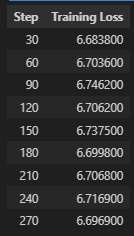 - solar

In [89]:
gen(chat=chat) # solar 10.7B epoch 1

/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:492: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.6` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/donghae/anaconda3/envs/llm/lib/python3.9/site-packages/transformers/generation/utils.py:1460: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(


"<s> ### 사용자 채팅: ['안녕, 잘 지냈어? 2일만이네.', '응, 혹시 반려동물을 키워? 요즘 유기견이 많더라.', '대단하네. 나도 가끔 외로워서 반려동물을 키워보고 싶은데, 유기견을 입양해볼까 고민이 많아.', '맞아. 유기견 봉사활동 같은 것도 많은 것 같아. 나중에 기회가 되면 한번 가봐야겠어.', '요즘 밴드나 알아볼 수 있는 방법들이 많다고 들었어.  찾아보면 될 것 같아.', '맞아, 혼자 가서 할 수 있는 일도 아니야. 한번 알아봐.', '아니, 나도 관심은 있는데, 키우기는 조금 부담이 돼.']</끝>\n### 사용자 페르소나: 20대, 여성, 반려동물, 유기견, 봉사활동, 밴드</끝>\n상기 표 1을 참조하면, 사용자 채팅은 사용자가 입력한 채팅 내용이고, 사용자 페르소나는 상기 사용자 채팅으로부터 추출된 키워드이다.\n도 2는 본 발명의 일 실시예에 따른 사용자 페르소나를 추출하는 방법을 설명하기 위한 도면이다.\n도 2를 참조하면"

### Merge

In [47]:
base_model = AutoModelForCausalLM.from_pretrained(
    'EleutherAI/polyglot-ko-1.3b',
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map={"": 0},
    cache_dir='./cache'
)
model = PeftModel.from_pretrained(base_model, './saved/polyglot-ko-1.3b-1ep')
model = model.merge_and_unload()

Loading checkpoint shards: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]
